In [3]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
!pip install datasets
from datasets import load_dataset
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import random
import re
from sklearn.manifold import TSNE


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# get dataset from huggingface
data = load_dataset("imdb")

# get the reviews as array
movie_reviews = np.array(data["unsupervised"].data["text"])

# tokenize the dataset and remove punctuations
movie_reviews_clean = []
for review in movie_reviews:
    movie_reviews_clean.append([re.sub("[^\w]", "", word.lower()) for word in word_tokenize(review)])


clean_reviews = []
for review in movie_reviews_clean:
  review = list(filter(lambda x: x!= "", review))
  clean_reviews.append(review)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
def mapping(tokens):
  flat_tokens = []
  for token in tokens:
    flat_tokens.extend(token)
  word_to_id = {}
  id_to_word = {}

  for i, token in enumerate(set(flat_tokens)):
      word_to_id[token] = i
      id_to_word[i] = token

  return word_to_id, id_to_word

word_to_id, id_to_word = mapping(clean_reviews)

In [6]:
len(word_to_id)

140866

In [7]:
np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)

    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i),
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(word_to_id[tokens[i]])
            y.append(word_to_id[tokens[j]])

    return np.asarray(X), np.asarray(y)

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return np.array(res)

In [8]:
X = []
y = []

for review in clean_reviews:
  cur_X, cur_y = generate_training_data(review, word_to_id, 2)
  X.extend(cur_X)
  y.extend(cur_y)



In [9]:
X, y = zip(*random.sample(list(zip(X, y)), 100))
X = np.array(X)
y = np.array(y)

In [10]:
X.shape

(100,)

In [11]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [12]:
model = init_network(len(word_to_id), 300)

In [13]:
def softmax(X):
  res = []
  for x in X:
    exp = np.exp(x)
    res.append(exp / exp.sum())
  return np.array(res)

def encode_mat_mul(X, Y, T = False):
  result = []
  if not T:
    for i in range(len(X)):
      result.append(one_hot_encode(X[i], len(word_to_id)) @ Y)
  else:
    tmp = []
    for i in range(len(X)):
      tmp.append(one_hot_encode(X[i], len(word_to_id)))
    return np.array(tmp).T @ Y
  return np.array(result)

def encode_mat(y):
  result = []
  for i in y:
    result.append(one_hot_encode(i, len(word_to_id)))
  return np.array(result)



def forward(model, X, return_cache = True):
  cache = {}
  cache['a1'] = encode_mat_mul(X, model['w1'])
  cache['a2'] = cache['a1'] @ model['w2']
  cache['Z'] =  softmax(cache['a2'])

  if not return_cache:
    return cache['Z']
  return cache

In [14]:
(encode_mat_mul(X[:10], model['w1']) @ model['w2']).shape


(10, 140866)

In [15]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

def encode_minus(Z, y):
  result = []
  for i in range(len(y)):
    result.append(Z[i] - one_hot_encode(y[i], len(word_to_id)))
  return np.array(result)

def backward(model, X, y, alpha):
  cache = forward(model, X)
  da2 = encode_minus(cache['Z'], y)
  # print(da2.shape)
  dw2 = cache['a1'].T @ da2
  # print(dw2.shape)
  da1 = da2 @ model['w2'].T
  # print(da1.shape)
  dw1 = encode_mat_mul(X, da1, True)
  # print(dw1.shape)
  assert(dw2.shape == model["w2"].shape)
  assert(dw1.shape == model["w1"].shape)
  model["w1"] -= alpha * dw1
  model["w2"] -= alpha * dw2
  return cross_entropy(cache["Z"], encode_mat(y))

In [16]:
backward(model, X, y, 0.05)

7624.416305656013

<ipython-input-17-02e4b40088ca>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


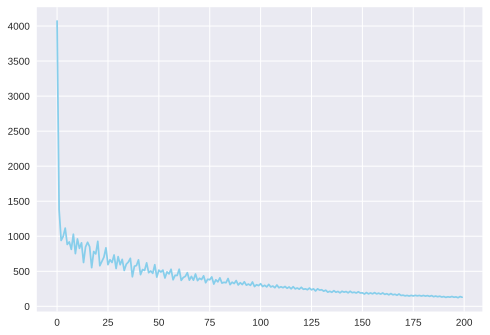

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 200
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [24]:
embedding = forward(model, X)['a1']
X_embedded = np.array(TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embedding))

In [28]:
labels = []
for word in X:
  labels.append(id_to_word[word])
labels

['got',
 'peter',
 'quite',
 'do',
 'killer',
 'surpasses',
 'christie',
 'revelation',
 'for',
 'said',
 'this',
 'and',
 'it',
 'unbelievable',
 'i',
 'can',
 'everything',
 'a',
 'and',
 'be',
 'arrive',
 'seemed',
 'material',
 'pretty',
 'often',
 'deodorant',
 'a',
 'got',
 'be',
 'depth',
 'of',
 'movie',
 'former',
 'permission',
 'a',
 'attention',
 'starred',
 'in',
 'cruelty',
 'i',
 'in',
 'of',
 'having',
 'in',
 'the',
 'bit',
 'right',
 'that',
 'the',
 'very',
 'everybody',
 'unstoppable',
 'musante',
 'his',
 'discovered',
 'like',
 'your',
 'it',
 'movement',
 's',
 'times',
 'discuss',
 'br',
 'worse',
 'with',
 'and',
 'of',
 'make',
 'film',
 'better',
 'hold',
 'roadhouse',
 'tank',
 'to',
 'poverty',
 'of',
 'human',
 'people',
 'have',
 'why',
 'focus',
 'and',
 'on',
 'harriet',
 'an',
 'there',
 'typical',
 'too',
 'to',
 'make',
 'island',
 'fact',
 'and',
 'who',
 'in',
 'hand',
 'this',
 'empathy',
 'has',
 'about']

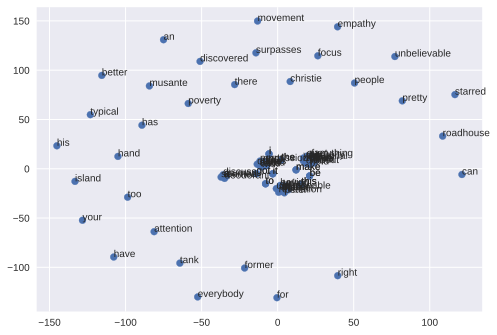

In [33]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

for i, label in enumerate(labels):
    ax.annotate(label, (X_embedded[:, 0][i], X_embedded[:, 1][i]))
